In [1]:
from matplotlib import animation
from pprint import pprint
import ray
%matplotlib notebook

from run import *

In [3]:
def run_evaluation(agent_run_names, agent_checkpoints, config_name, policy_name="ppo", seed=1):
    ray.shutdown()
    ray.init()
    config = load_config(config_name)
    eval_run_name = ""
    for i in range(len(agent_run_names)):
        eval_run_name += f"{agent_run_names[i]}_{agent_checkpoints[i]}_"
    eval_run_name = eval_run_name[:-1]
    ray_dir = f"{os.path.expanduser('~')}/ray_results"
    eval_results_dir = f"{ray_dir}/{eval_run_name}"
    register_env("ZSC-Cleaner", lambda _: CleanerEnv(config["env_config"], run_name=eval_run_name))

    agents = {}
    for i in range(config["env_config"]["num_agents"]):
        agent = Agent(
            policy_name=policy_name,
            run_name=agent_run_names[i],
            agent_num=i,
            config=config,
            seed=seed,
            heterogeneous=True
        )
        agents[agent.name] = agent
        trainer_agents = {}
        for other_agent_num in range(agent.config["env_config"]["num_agents"]):
            other_agent = deepcopy(agent)
            other_agent.agent_num = other_agent_num
            other_agent.name = f"{agent.run_name}:{other_agent_num}"
            trainer_agents[other_agent.name] = other_agent
        agent.trainer = create_trainer(
            agent.policy_name,
            trainer_agents, 
            agent.config, 
            agent.results_dir, 
            seed=agent.seed, 
            heterogeneous=agent.heterogeneous, 
            num_workers=1
        )
        checkpoint_num = agent_checkpoints[i]
        checkpoint_path = f"{ray_dir}/{agent.run_name}/checkpoint_" \
                          f"{str(checkpoint_num).zfill(6)}/checkpoint-{checkpoint_num}"
        agent.trainer.load_checkpoint(checkpoint_path)
    
    ani = evaluate(
        agents,
        config,
        eval_run_name,
        num_episodes=1,
        record=True,
    )
    return ani

2021-08-23 18:21:49,566	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-23 18:21:51,401	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-08-23 18:21:53,988	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-23 18:21:56,415	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


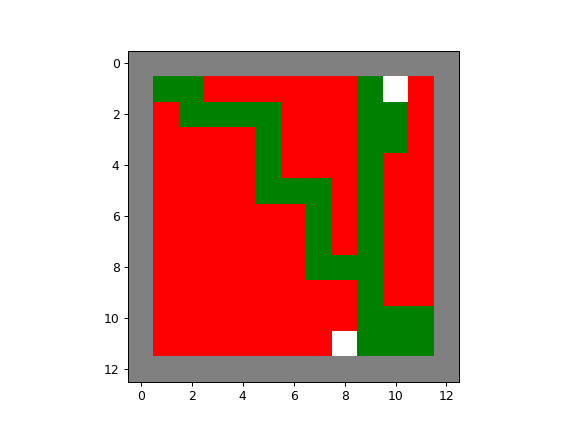

saved video at /home/anchorwatt/ray_results/simple123_501_simple456_501/video.mp4
episode rewards: [13.0] (mean = 13.0)


In [4]:
agent_run_names = ["simple123", "simple456"]
agent_checkpoints = [501, 501]
config_name = "simple_11x11"

run_evaluation(
    agent_run_names, 
    agent_checkpoints, 
    config_name, 
    policy_name="ppo", 
    seed=1
)